# Reinforcement Learning
Author: Jin Yeom (jinyeom@utexas.edu)

## Contents
- [Q-learning](#Q-learning)
- [REINFORCE](#REINFORCE)
- [REINFORCE with baseline](#REINFORCE-with-baseline)
- [Actor-critic](#Actor-critic)
- [Advantage Actor-critic (A2C)](#Advantage-Actor-critic-%28A2C%29)

NOTE: This notebook covers basics of [reinforcement learning](https://en.wikipedia.org/wiki/Reinforcement_learning). More advanced RL algorithms will be explored in separate notebooks.

In [45]:
import gym
import numpy as np
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torchsummary import summary

In [4]:
%matplotlib notebook

## Q-learning

Let's begin with the **Q-learning** algorithm, which is based on the following learning rule,

$$
Q'(s_t, a_t) \leftarrow (1 - \alpha)Q(s_t, a_t) + \alpha(r_t + \gamma \max_{a}Q(s_{t + 1}, a))
$$

which is often written rearranged for convenience, as follows

$$
Q'(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha(r_t + \gamma \max_{a}Q(s_{t + 1}, a) - Q(s_t, a_t))
$$

where the term $r_t + \gamma \max_{a}Q(s_{t + 1}, a) - Q(s_t, a_t)$ directly describes the "error" in Q values.

In [5]:
def update(q_table, obs, action, reward, next_obs, alpha, gamma):
    diff = reward + gamma * np.max(q_table[next_obs, :]) - q_table[obs, action]
    q_table[obs, action] = q_table[obs, action] + alpha * diff

In [6]:
def q_learning(q_table, env, alpha, gamma, epsilon, n_iters, n_eps):
    ep_log = [] # record length and total reward of each episode
    for ep in tqdm(range(n_eps)):
        obs = env.reset()
        i = total_reward = done = 0
        while not done and i < n_iters:
            # ε-greedy is applied for exploration, in which by some probability ε,
            # a random action is chosen, instead of the reward maximizing action.
            action = np.random.choice([env.action_space.sample(), np.argmax(q_table[obs, :])],
                                      p=[epsilon, 1 - epsilon])
            next_obs, reward, done, _ = env.step(action)
            update(q_table, obs, action, reward, next_obs, alpha, gamma)
            total_reward += reward
            obs = next_obs
            i += 1
        ep_log.append((i, total_reward))
    return ep_log

For this section, we're going to use a simple Grid World based environment called **Frozen Lake**.

In [27]:
env = gym.make("Taxi-v2")
print(env.observation_space)
print(env.action_space)

Discrete(500)
Discrete(6)


In [53]:
q_table = np.zeros((env.observation_space.n, env.action_space.n))
ep_log = q_learning(q_table, env, 0.1, 0.9, 0.2, 200, 3000)
durations, total_rewards = zip(*ep_log)

<IPython.core.display.Javascript object>


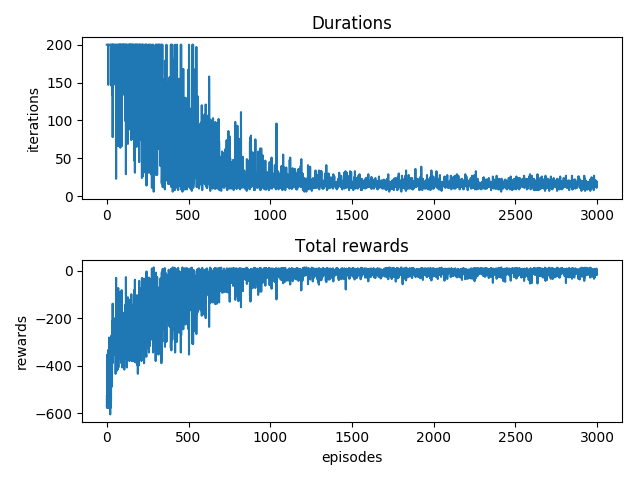

In [54]:
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.set_title("Durations")
ax1.set_ylabel("iterations")
ax1.plot(durations)

ax2.set_title("Total rewards")
ax2.set_ylabel("rewards")
ax2.plot(total_rewards)

plt.xlabel("episodes")
plt.tight_layout()
plt.show()

In [55]:
obs = env.reset()
done = False
while not done:
    env.render()
    action = np.argmax(q_table[obs, :])
    obs, reward, done, info = env.step(action)

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
|_| : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : : : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
|_: : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)


That was fun and all, but Q-learning (or its [deep learning varient from DeepMind](https://deepmind.com/research/dqn/), which is explored in a different notebook) turned out to be not so useful, as it can't be used for continuous control tasks. Policy optimization, which optimizes the agent's policy directly, is currently a popular alternative. There are several methods of policy optimization, including evolutionary algorithms, but in this notebook, we'll focus on gradient-based methods, namely **policy-gradient** methods.

## REINFORCE

Among various policy gradient methods, **REINFORCE** (**RE**ward **I**ncrement = **N**onnegative **F**actor times **O**ffset **R**einforcement times **C**haracter **E**ligibility; *I know, may it never come up again*), is the most naive. The core idea of this algorithm is the following update rule:

$$
\theta_{t + 1} = \theta_t + \alpha G_t \frac{\Delta\pi(A_t \big\lvert S_t, \theta_t)}{\pi(A_t \big\lvert S_t, \theta_t)}
$$

In [56]:
env = gym.make("Acrobot-v1") # some continuous control task
print(env.observation_space)
print(env.action_space)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Box(6,)
Discrete(3)


In [62]:
class Policy(nn.Module):
    def __init__(self, in_features, out_features):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(in_features, 128)
        self.fc2 = nn.Linear(128, out_features)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        # return log probability of each action
        return F.log_softmax(self.fc2(x), dim=-1)

In [63]:
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n
summary(Policy(obs_dim, act_dim), (obs_dim,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]             896
            Linear-2                    [-1, 3]             387
Total params: 1,283
Trainable params: 1,283
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


## REINFORCE with baseline

## Actor-critic

## Advantage Actor-critic (A2C)

## References
1. https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0
2. http://www.cs.utexas.edu/~sniekum/classes/343-S18/lectures/lecture12.pdf